In [11]:
%pylab inline
import matplotlib
import matplotlib.pyplot as plt
import sys
import numpy as np
from tables import open_file
import pickle
import networkx as nx
from IPython.display import Image

from pathway_restraints import sea_restraint, dock_restraint, cmetab_restraint, tfluor_restraint, evidence_restraint, dataTables
from sample_graph import Paths
import graph_drawing as gd

sys.path.append('/trombone1/home/scalhoun/pathway')
from reaction_calculations import ligandData
import pathway_analysis as pa
import backtracking as bt

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Useful functions working with Networkx graphs

In [5]:
def compare_graphs(PredG, TrueG):
    edges_pred = PredG.edges()
    edges_true = TrueG.edges()
    
    found_edges = []
    missed_edges = []
    
    for edge in edges_true:
        if edge in edges_pred:
            found_edges.append(edge)
        else:
            missed_edges.append(edge)
        
    TP = len(found_edges)
    FP = len(edges_pred) - TP
    FN = len(edges_true) - TP
    
    TPR = float(TP)/(TP+FN)
    Precision = float(TP)/(TP+FP)
    #print "TPR:", TPR
    #print "Precision:", Precision
    
    return TPR, Precision

def make_reference_graph(current_proteins):
    true_edges_subenz = [('C00031_2', '1'), ('C00092_4', '2'), ('C00085_2', '3'), ('C00354_1', '4'), 
        ('C00111_1', '5'), ('C00118_2', '6'), ('C00236_3', '7'), ('C00197_1', '8'), 
        ('C00631_1', '9'), ('C00074_1', '10')]
    true_edges_enzprod = [('1', 'C00092_4'), ('2', 'C00085_2'), ('3', 'C00354_1'), ('4', 'C00111_1'),
        ('5', 'C00118_2'), ('6', 'C00236_3'), ('7', 'C00197_1'), ('8', 'C00631_1'), 
        ('9', 'C00074_1'), ('10', 'C00022_1'), ('4', 'C00118_2')]
    nodes = []
    edges = []
    tese_curr = []
    teep_curr = []
    for tese in true_edges_subenz:
        if (tese[1] in current_proteins):
            nodes.append(tese[0])
            nodes.append(tese[1])
            edges.append(tese)
            tese_curr.append(tese)
    for teep in true_edges_enzprod:
        if (teep[0] in current_proteins):
            nodes.append(teep[0])
            nodes.append(teep[1])
            edges.append(teep)
            teep_curr.append(teep)
    nodes = list(set(nodes))

    G = nx.MultiDiGraph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    return G, tese_curr, teep_curr

def pathway_strings_to_graph(paths):
    nodes = []
    edges = []
    
    for currpath in paths:
        currnodes = currpath.split(' -> ')
        nodes.extend(currnodes)
        for n in range(len(currnodes)-1):
            edge = (currnodes[n], currnodes[n+1])
            edges.append(edge)
            
    nodes = list(set(nodes))
    edges = list(set(edges))
    
    H = nx.MultiDiGraph()
    H.add_nodes_from(nodes)
    H.add_edges_from(edges)
    return H

In [35]:
# Reactions
transferase=["[C:1][O:2][H]>>[C:1][O:2][P]([O])([O])=O"]
kinase=transferase
revtransferase=['[C:1][O:2][P]([OH])([OH])=O>>[C:1][O:2]']
revenolase=["[H][C:1][C:2][O][H]>>[C:1]=[C:2]"]
pyruvatekinase=["[C:1]=[C:2][O:3][P]([O])([O])=O>>[H][C:1][C:2]=[O:3]"]
mutase=["[O:5][P:6]([O:7])(=[O:8])[O:4][C:1][C:2][O:3][H]>>[H][O:4][C:1][C:2][O:3][P:6]([O:5])([O:7])(=[O:8])"]
isomerase=["[O:3][C:2][CH:1]>>[O:3][C:1][CH:2]"]
esterase=["[C:1][O:2][P]([O])([O])=O>>[C:1][O:2][H]"]
dehydrogenaseP=["[O:2]=[C:1][H]>>[O:2]=[C:1][O][P](O)(O)=O"]
aldolase=["[H][O:1][C:2](A)[C:3][O:4]A>>[O:1]=[C:2][C:3][O:4][H]", 
          "A[C:1]([O:2][H])[C:3]([O:4][H])A>>[O:2]=[C:1][C:3]([O:4][H])[H]"]
aldolase = ['[O:1]=[C:2][C:3][CH]([OH])[CH]([OH])A>>[O:1]=[C:2][C:3][H]',
            'O=C(A)C[C:2]([O:1][H])[C:3][O:4][H]>>[O:1]=[C:2][C:3][O:4][H]']
aldose_ketose_isomerase=["[H][O:1][C:2]([H])[C:3](=[O:5])[C:4]>>[O:1]=[C:2][C:3]([H])([O:5][H])[C:4]"]
reactions = {'3':transferase, '1':transferase, '2':isomerase, '4':aldolase,
             '6':dehydrogenaseP, '7':revtransferase,
                 '8':mutase, '9':revenolase, '5':aldose_ketose_isomerase, '10':pyruvatekinase}

# FILENAMES
smilesfile = 'glyco/gly_candidate_dups_removed.txt'
outfile = 'glyco/gly_reactions.txt'

seafile = 'glyco/glycolysis_sea.txt'
datafile = 'glyco/gly_enum_data_3.h5'
h5out = 'glyco/gly_solutions.h5'
picklefile = 'glyco/gly_solutions.pickle'

enzymes = reactions.keys()
#proteins = dockfiles.keys()

##Create data files and possible reaction sets
On server, generated the following files:
- `glyco/gly_enum_data_3.h5`
- `glyco/gly_reactions.txt`

These files can be generated by the following commands:
```
dockfiles = {}
dockfiles['1'] = 'scores/gly1_scores.txt'
dockfiles['2'] = 'scores/gly2_scores.txt'
dockfiles['3'] = 'scores/gly3_scores.txt'
dockfiles['4'] = 'scores/gly4_scores.txt'
dockfiles['5'] = 'scores/gly5_scores.txt'
dockfiles['6'] = 'scores/gly6_scores.txt'
dockfiles['7'] = 'scores/gly7_scores.txt'
dockfiles['8'] = 'scores/gly8_scores.txt'
dockfiles['9'] = 'scores/gly9_scores.txt'
dockfiles['10'] = 'scores/gly10_scores.txt'
smilesfile = 'glyco/gly_candidate_dups_removed.txt'
seafile = 'glyco/glycolysis_sea.txt'

outfile = 'glyco/gly_reactions.txt'
datafile = 'glyco/gly_enum_data_3.file'

lig = ligandData(datafile=datafile,
                 smilesfile=smilesfile,
                 delimiter=';',
                 keepmultiples=True)
lig.save_docking_scores(dockfiles, id_column=1, score_column=2, delimiter=';')
lig.save_sea_scores(seafile, proteinlist=dockfiles.keys())
lig.save_reaction_scores(reactions) # For Monte Carlo
lig.write_possible_reaction_sets(reactions, outfile) # For enumeration
```

##Enumerate solutions

On server, generated possible solutions:
- `glyco/gly_solutions.pickle`

These solutions can be generated by the following commands:
```
rxns = bt.read_in_reactions(outfile)
bt.enumerate_pathways(rxns, 10, picklefile, minlength=9)


> Number of solutions: 12046
> Number of solutions: 43248
> Number of solutions: 137156
> Number of solutions: 296495
> Number of solutions: 325120
> Number of solutions: 125956
> Number of solutions: 75526
> Number of solutions: 11520
> Number of solutions: 6048
> Writing 17568 pathway solutions to glyco/gly_solutions.pickle
```

##Score possible solutions

In [37]:
with open(picklefile, 'r') as handle:
    solution_list = pickle.load(handle)
    
print len(solution_list)

d = dataTables()
d.readInLigands(smilesfile, delimiter=';', keepmultiples=True)
d.readInSelectedTables(datafile, ['dock', 'sea'])

with open_file(h5out, 'w') as h5outhandle:
    ps = Paths(d, h5outhandle)
    sr = sea_restraint()
    dr = dock_restraint()
    
    restraints = [dr]
    ps.score_solutions(solution_list, restraints)

17568
5034 ligands from glyco/gly_candidate_dups_removed.txt
Best Observed: C02076_2 -> 1 -> C06222_19 -> 3 -> C00447_57 -> 4 -> C00111_1 -> 5 -> C00118_2 -> 6 -> C00236_3 -> 7 -> C00197_1 -> 8 -> C00631_1 -> 9 -> C00074_1 -> 10 -> C00022_1
docking score: 7.359
OBJ: 7.359


##Filter possible solutions to good scoring solutions

In [39]:
pathar = pa.load_pathway_scores(h5out)
ps.data.proteins = enzymes
goodsolns = ps.filter_solutions_by_stats(pathar, 10000, restraints)

17568 paths filtered down to 353 within 1.0 standard deviation(s)


##Cluster good scoring solutions

In [40]:
gclusters, reprcl = pa.cluster_pathways(goodsolns, threshold=0.1)

353 paths clustered into 15 groups


##Visualize network models

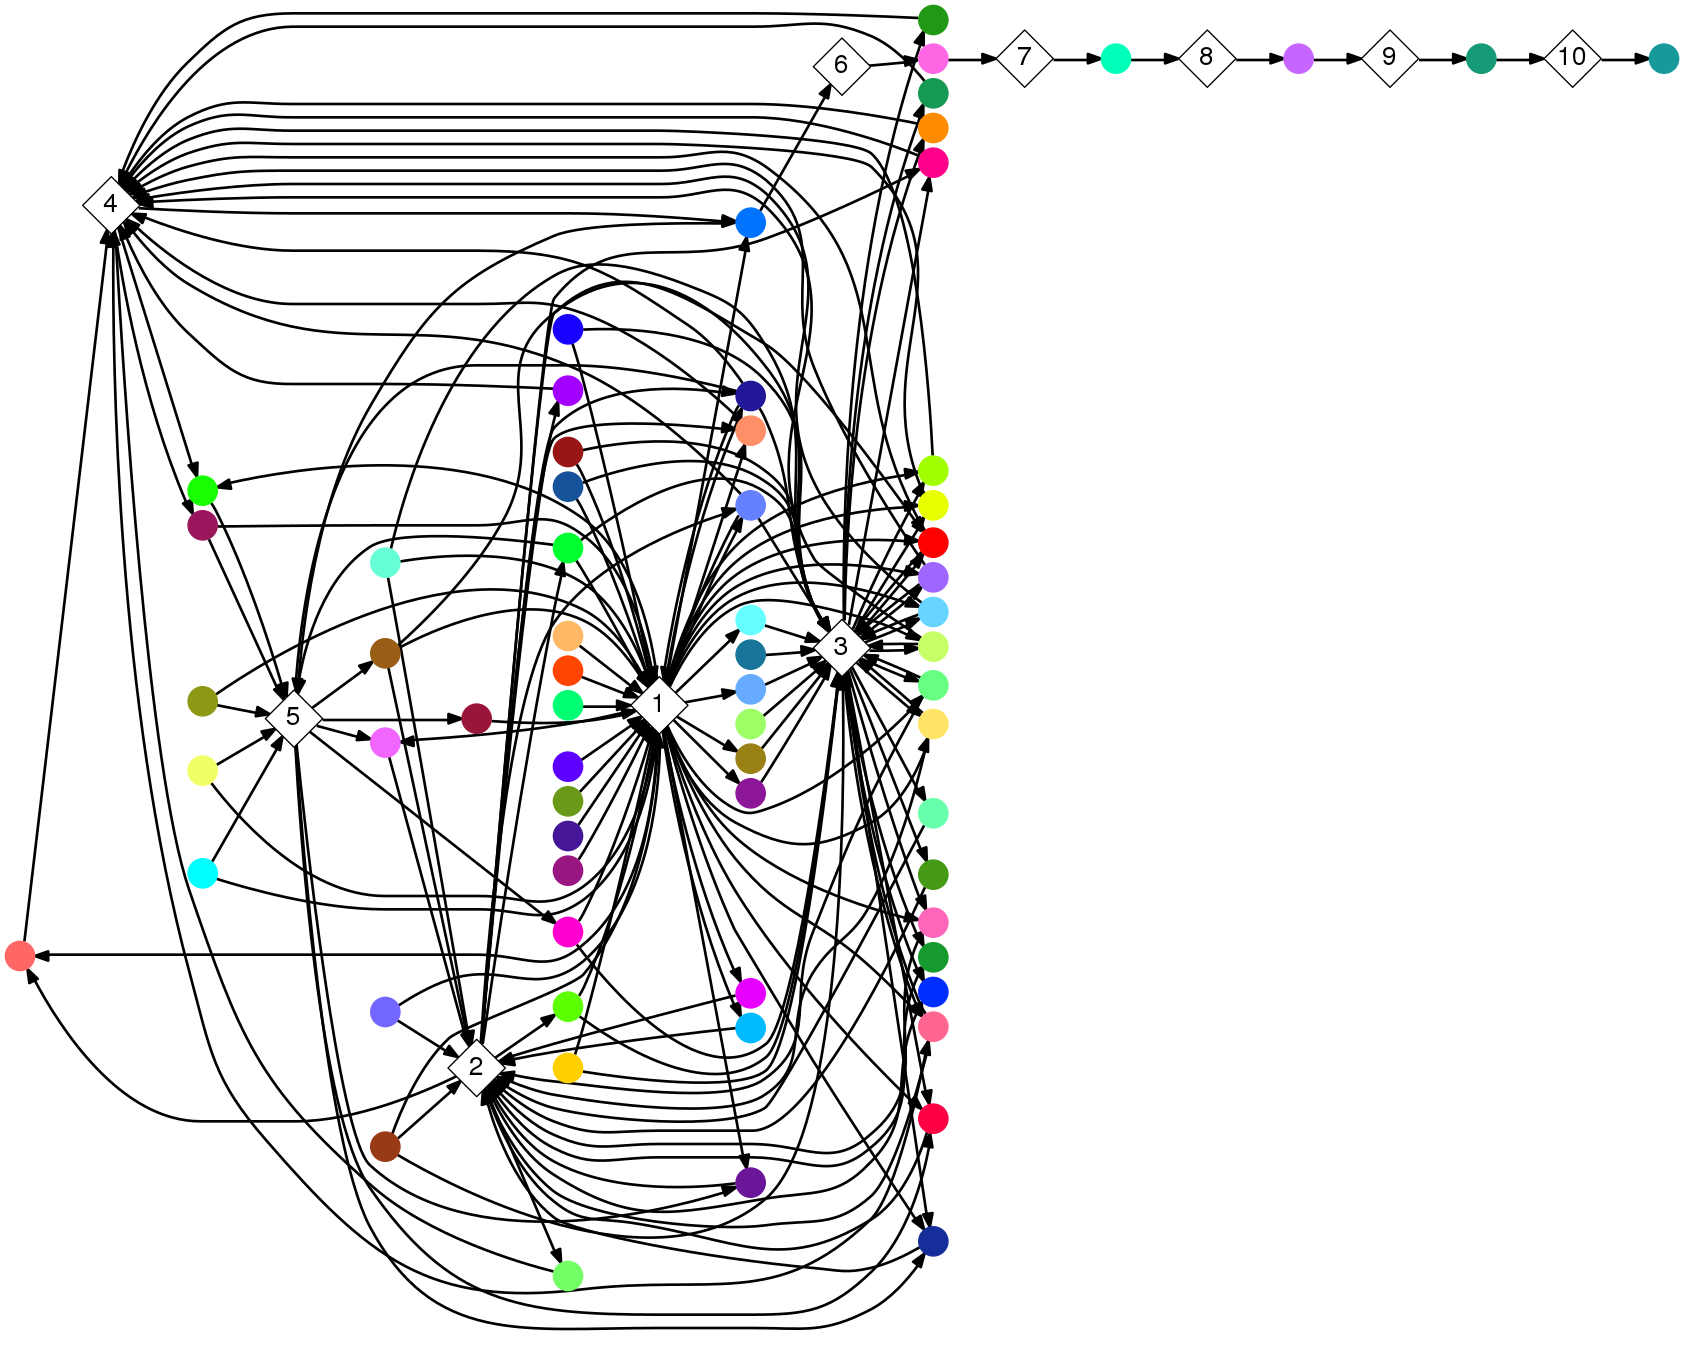

In [41]:
imgfile = 'glyco/graph_pics/image.png'
nodecolors = gd.make_graph_img_net_single(goodsolns['strrepr'], imgfile, fontsize=20,
                            circlelabels=False, diamondlabels=True, directed=True)
Image(imgfile)

/trombone1/home/scalhoun/pics/graphs/gly_colors_image.png


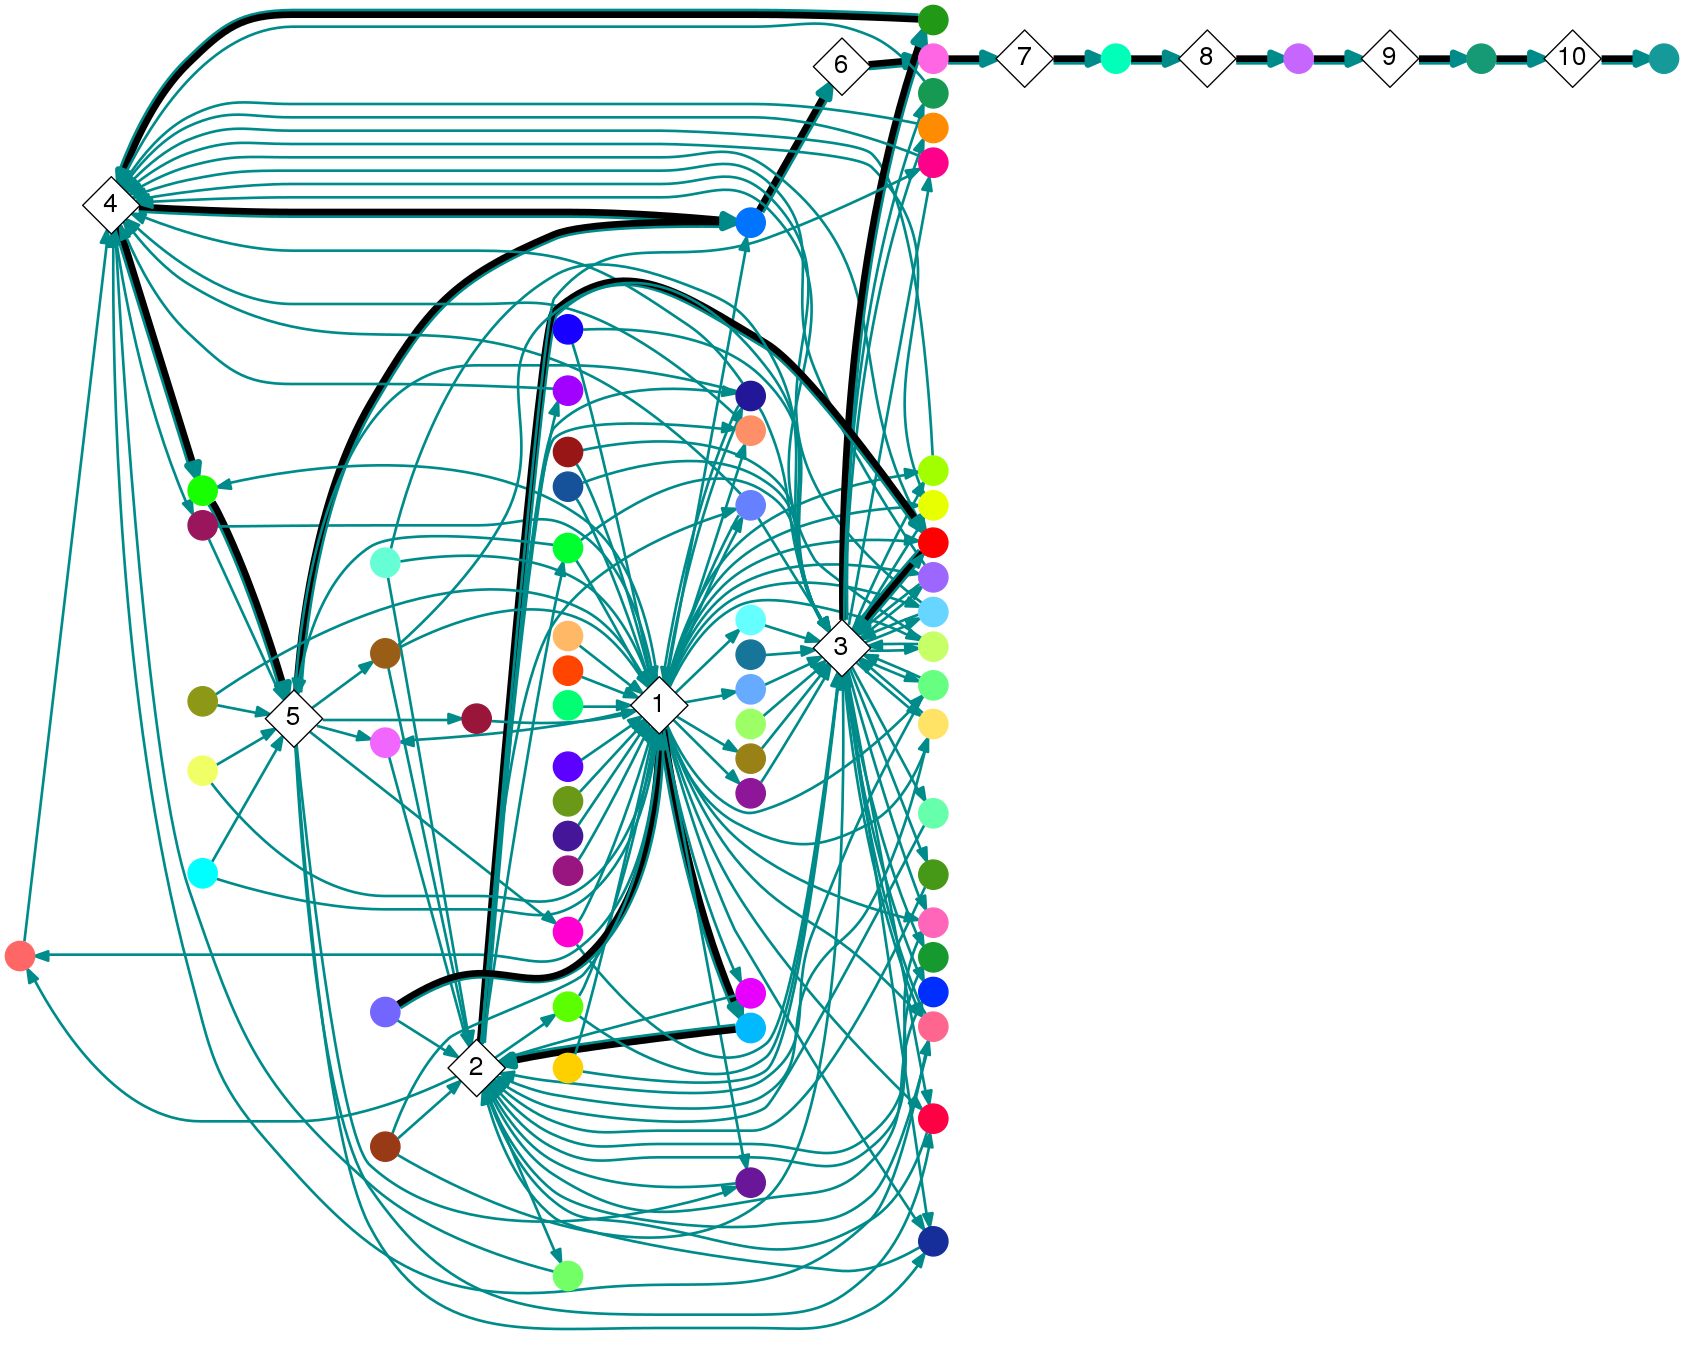

In [42]:
tese = [('C00031_2', '1'), ('C00092_4', '2'), ('C00085_2', '3'), ('C00354_1', '4'), 
        ('C00111_1', '5'), ('C00118_2', '6'), ('C00236_3', '7'), ('C00197_1', '8'), 
        ('C00631_1', '9'), ('C00074_1', '10')]
teep = [('1', 'C00092_4'), ('2', 'C00085_2'), ('3', 'C00354_1'), ('4', 'C00111_1'),
        ('5', 'C00118_2'), ('6', 'C00236_3'), ('7', 'C00197_1'), ('8', 'C00631_1'), 
        ('9', 'C00074_1'), ('10', 'C00022_1'), ('4', 'C00118_2')]
imgfile = 'glyco/graph_pics/gly_colors_image.png'
print imgfile
gd.make_graph_img_net_single(goodsolns['strrepr'], imgfile, nodecolordict=nodecolors, fontsize=20,
                              circlelabels=False, diamondlabels=True, directed=True,
                              true_edges_subenz=tese, true_edges_enzprod=teep)
Image(imgfile)

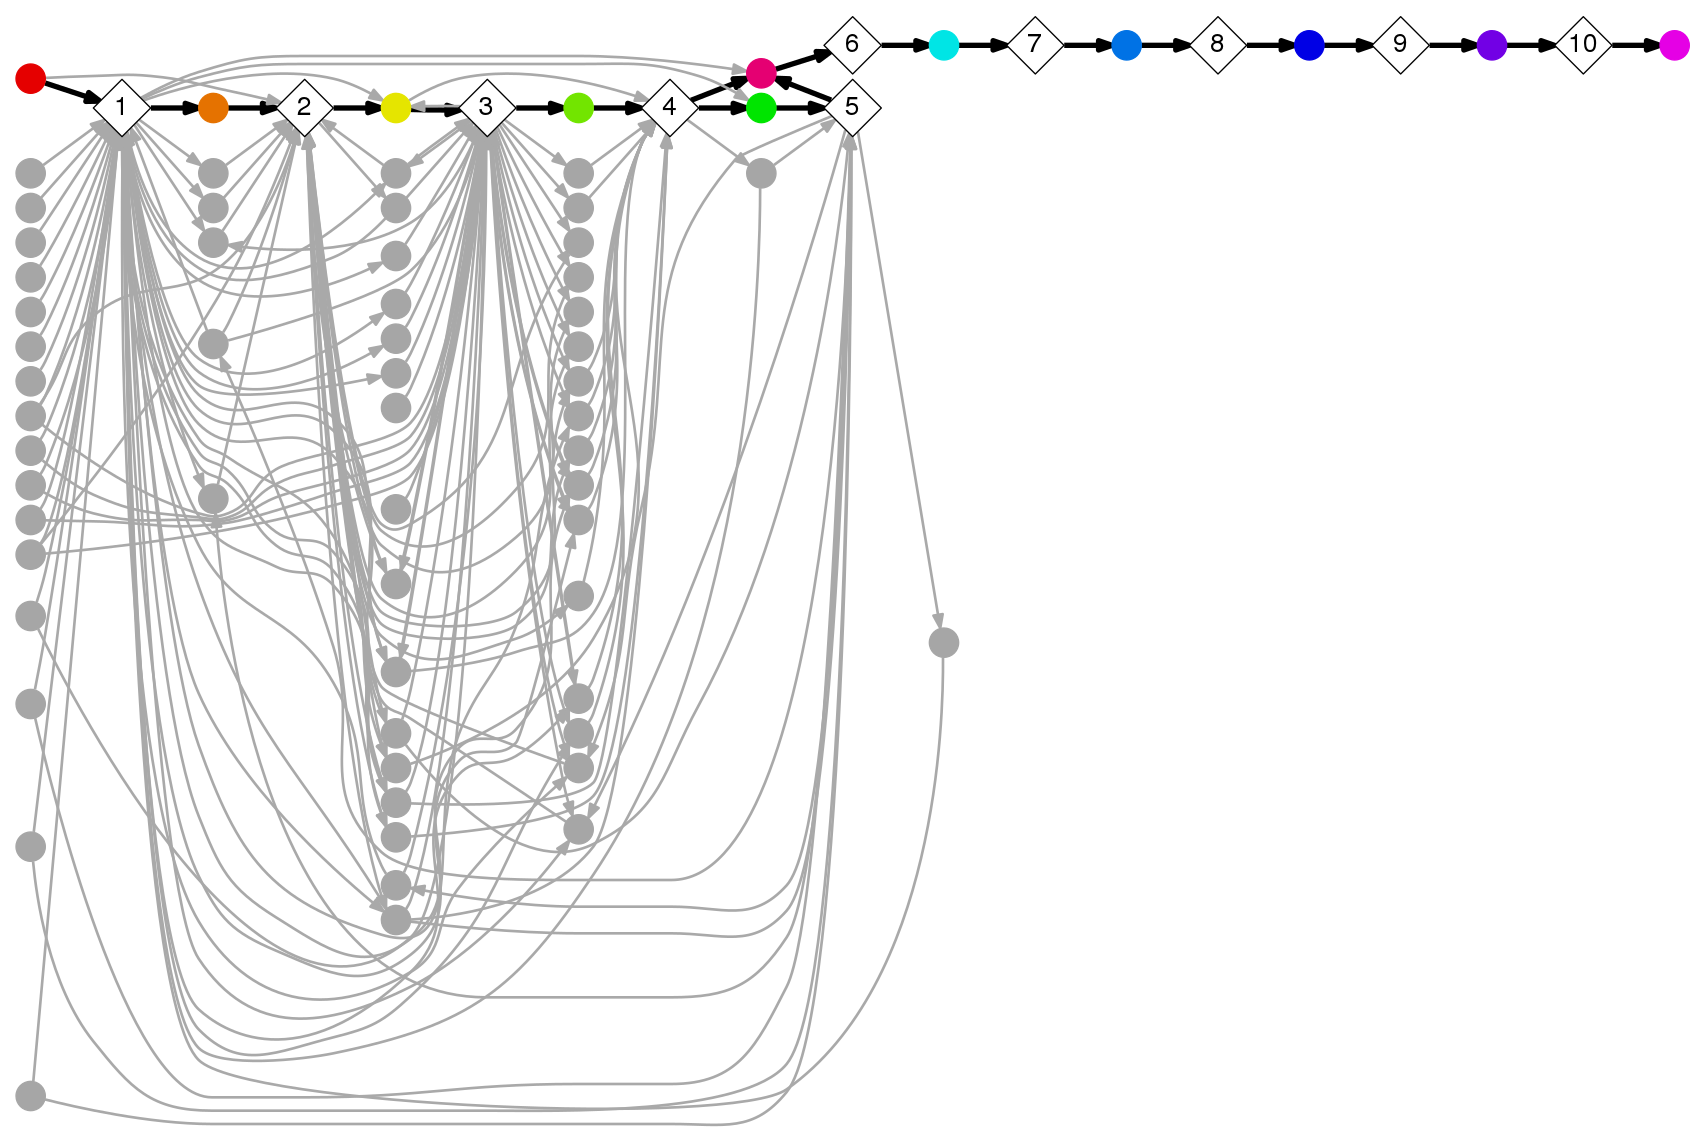

In [13]:
import pygraphviz as pgv

tese = [('C00031_2', '1'), ('C00092_4', '2'), ('C00085_2', '3'), ('C00354_1', '4'), 
        ('C00111_1', '5'), ('C00118_2', '6'), ('C00236_3', '7'), ('C00197_1', '8'), 
        ('C00631_1', '9'), ('C00074_1', '10')]
teep = [('1', 'C00092_4'), ('2', 'C00085_2'), ('3', 'C00354_1'), ('4', 'C00111_1'),
        ('5', 'C00118_2'), ('6', 'C00236_3'), ('7', 'C00197_1'), ('8', 'C00631_1'), 
        ('9', 'C00074_1'), ('10', 'C00022_1'), ('4', 'C00118_2')]

molecules = ['C00031_2', 'C00092_4', 'C00085_2', 'C00354_1',
        'C00111_1', 'C00118_2', 'C00236_3', 'C00197_1',
        'C00631_1', 'C00074_1', 'C00022_1', 'C00118_2']

cscale = gd.get_N_HexCol(len(molecules))
glynodecolors = {}
for m in range(len(molecules)):
    glynodecolors[molecules[m]] = '#%s' % cscale[m]


filename = 'glyco/graph_pics/glycolysis_network_benchmark.png'
G = pgv.AGraph('gly_graph.dot')
G1 = G.subgraph(nbunch=['C00031_2', '1', 'C00092_4', '2', 'C00085_2', '3', 'C00354_1', '4', 
                        'C00111_1', '5', 'C00118_2', '6', 'C00236_3', '7', 'C00197_1', '8',
                        'C00631_1', '9', 'C00074_1', '10', 'C00022_1'],
                name='cluster',
                style='invisible')
G2 = G1.subgraph(nbunch=['C00111_1', 'C00118_2'], name='cluster2')

tempnodecolordict = glynodecolors.copy()
enzs = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
for n in G.nodes():
    if n not in enzs:
        if n not in glynodecolors.keys():
            tempnodecolordict[n] = '#a6a6a6'
        n.attr['fillcolor'] = tempnodecolordict[n]
        n.attr['color'] = tempnodecolordict[n]
        
for edge in G.edges():
    #edgevals = edges[edge]
    edge.attr['penwidth'] = 2
    if edge in tese or edge in teep:
        edge.attr['color'] = 'black'
        edge.attr['penwidth'] = 4
    else:
        edge.attr['color'] = '#a9a9a9'
            
G.layout(prog='dot')
G.draw(filename)
Image(filename)

In [16]:
paths = goodsolns['strrepr']
G, lul, lol = make_reference_graph(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
H = pathway_strings_to_graph(paths)
netTPR, netPrec = compare_graphs(H, G)
H = pathway_strings_to_graph(pathar['strrepr'])

print "Number of edges in predicted network:", len(H.edges())
print "Number of nodes in predicted network:", len(H.nodes())
print "TPR of predicted network:", netTPR
print "Precision of predicted network:", netPrec

Number of edges in predicted network: 439
Number of nodes in predicted network: 138
TPR of predicted network: 1.0
Precision of predicted network: 0.12426035503


In [45]:
tprs = []
precs = []
pathar.sort(order='obj')
pathar = pathar[::-1]
#for i in range(1,len(pathar)+1):
for i in range(1,5000+1):
    goodsolns = pathar[0:i+1:]
    paths = goodsolns['strrepr']
    G, lul, lol = make_reference_graph(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'])
    H = pathway_strings_to_graph(paths)
    TPR, Prec = compare_graphs(H, G)

    tprs.append(TPR)
    precs.append(Prec)
    #fprs.append(FPR)


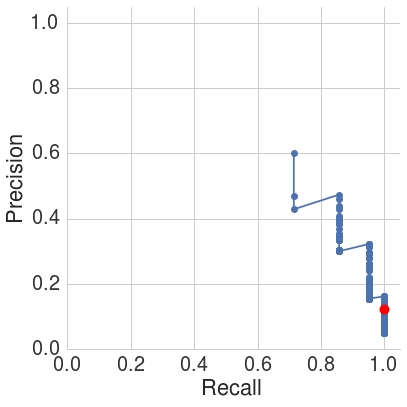

In [44]:
import seaborn as sns

sns.set(style="whitegrid", context="notebook", 
        rc={'font.sans-serif':['Helvetica'],
            'font.family':'sans-serif'}, 
        font_scale=2)
matplotlib.rcParams.update({'text.color':'#333333',
                            'font.size': 18, 
                            'text.usetex':True})
fontProperties = {'family':'sans-serif',
                  'color':'#333333'}

#fprs = [1-p for p in precs]
fig = plt.figure(figsize=(6,6))
ax = plt.subplot(1, 1, 1)
#ax.step(precs, tprs, '.')#, where='post')
ax.plot(tprs, precs, 'o-')
ax.plot([1.0], [0.124], 'ro', ms=10)
#ax.plot(tpr_df[3], prec_df[3], '.-')
ax.set_xlim([0, 1.05])
ax.set_ylim([0, 1.05])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_yticklabels(ax.get_yticks(), fontProperties)
ax.set_xticklabels(ax.get_xticks(), fontProperties)
sns.despine()
plt.tight_layout()
#plt.show()
plt.savefig('glyco/plots/gly_PR_Curve.png', dpi=300)

Note: The docking rank of glyceraldehyde 3-phosphate (C00118_2) to fructose disphosphate aldolase (Enzyme 4) is not high. Therefore, it is unexpected to easily recover this interaction in our predicted network. A less stringent cutoff (for determining what is a good scoring pathways) is needed in order to get these difficult edges/interactions.

In [ ]:
dockingscore = ps.data.dockdf.ix['4']['C00118_2'] 
print (ps.data.dockdf.ix['4'] > dockingscore).sum()
print len(ps.data.dockdf.ix['4'])

In [ ]:
for interaction in tese:
    greater_than_count = (ps.data.dockdf.ix[interaction[1]] > ps.data.dockdf.ix[interaction[1]][interaction[0]]).sum()
    #print len(ps.data.dockdf.ix[interaction[1]]) - greater_than_count
    print interaction, greater_than_count+1

In [ ]:
for interaction in teep:
    greater_than_count = (ps.data.dockdf.ix[interaction[0]] > ps.data.dockdf.ix[interaction[0]][interaction[1]]).sum()
    print interaction, greater_than_count+1

##Visualize individual clusters

In [29]:
for k in gclusters.keys():
    imgfile = 'glyco/graph_pics/cluster_image_%d.png' % k
    print imgfile
    gd.make_graph_img_net_single(gclusters[k], imgfile, nodecolordict=nodecolors, fontsize=10,
                              circlelabels=True, diamondlabels=True, directed=True)

/trombone1/home/scalhoun/pics/graphs/image_1.png
/trombone1/home/scalhoun/pics/graphs/image_2.png
/trombone1/home/scalhoun/pics/graphs/image_3.png
/trombone1/home/scalhoun/pics/graphs/image_4.png
/trombone1/home/scalhoun/pics/graphs/image_5.png
/trombone1/home/scalhoun/pics/graphs/image_6.png
/trombone1/home/scalhoun/pics/graphs/image_7.png
/trombone1/home/scalhoun/pics/graphs/image_8.png
/trombone1/home/scalhoun/pics/graphs/image_9.png
/trombone1/home/scalhoun/pics/graphs/image_10.png
/trombone1/home/scalhoun/pics/graphs/image_11.png
/trombone1/home/scalhoun/pics/graphs/image_12.png
/trombone1/home/scalhoun/pics/graphs/image_13.png
/trombone1/home/scalhoun/pics/graphs/image_14.png
/trombone1/home/scalhoun/pics/graphs/image_15.png


/trombone1/home/scalhoun/pics/graphs/image_2.png


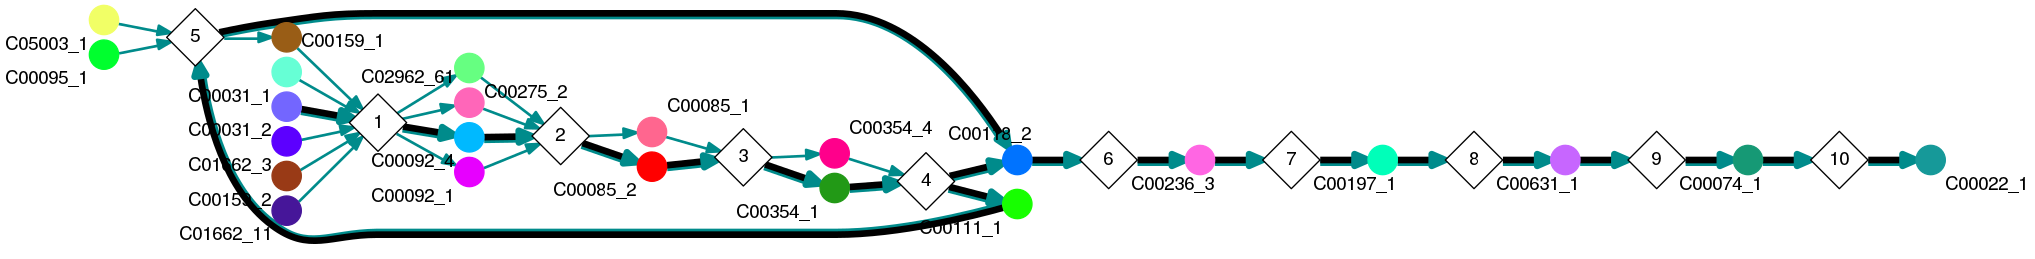

In [34]:
k=2
imgfile = 'glyco/graph_pics/cluster_labeled_image_%d.png' % k
print imgfile
gd.make_graph_img_net_single(gclusters[k], imgfile, nodecolordict=nodecolors, fontsize=14,
                              circlelabels=True, diamondlabels=True, directed=True,
                              true_edges_subenz=tese, true_edges_enzprod=teep)
Image(imgfile)

##Testing

/trombone1/home/scalhoun/.local/lib/python2.7/site-packages/pygraphviz/agraph.py:1343: RuntimeWarning: Warning: specified root node "0" was not found.Using default calculation for root node

  warnings.warn(b"".join(errors), RuntimeWarning)


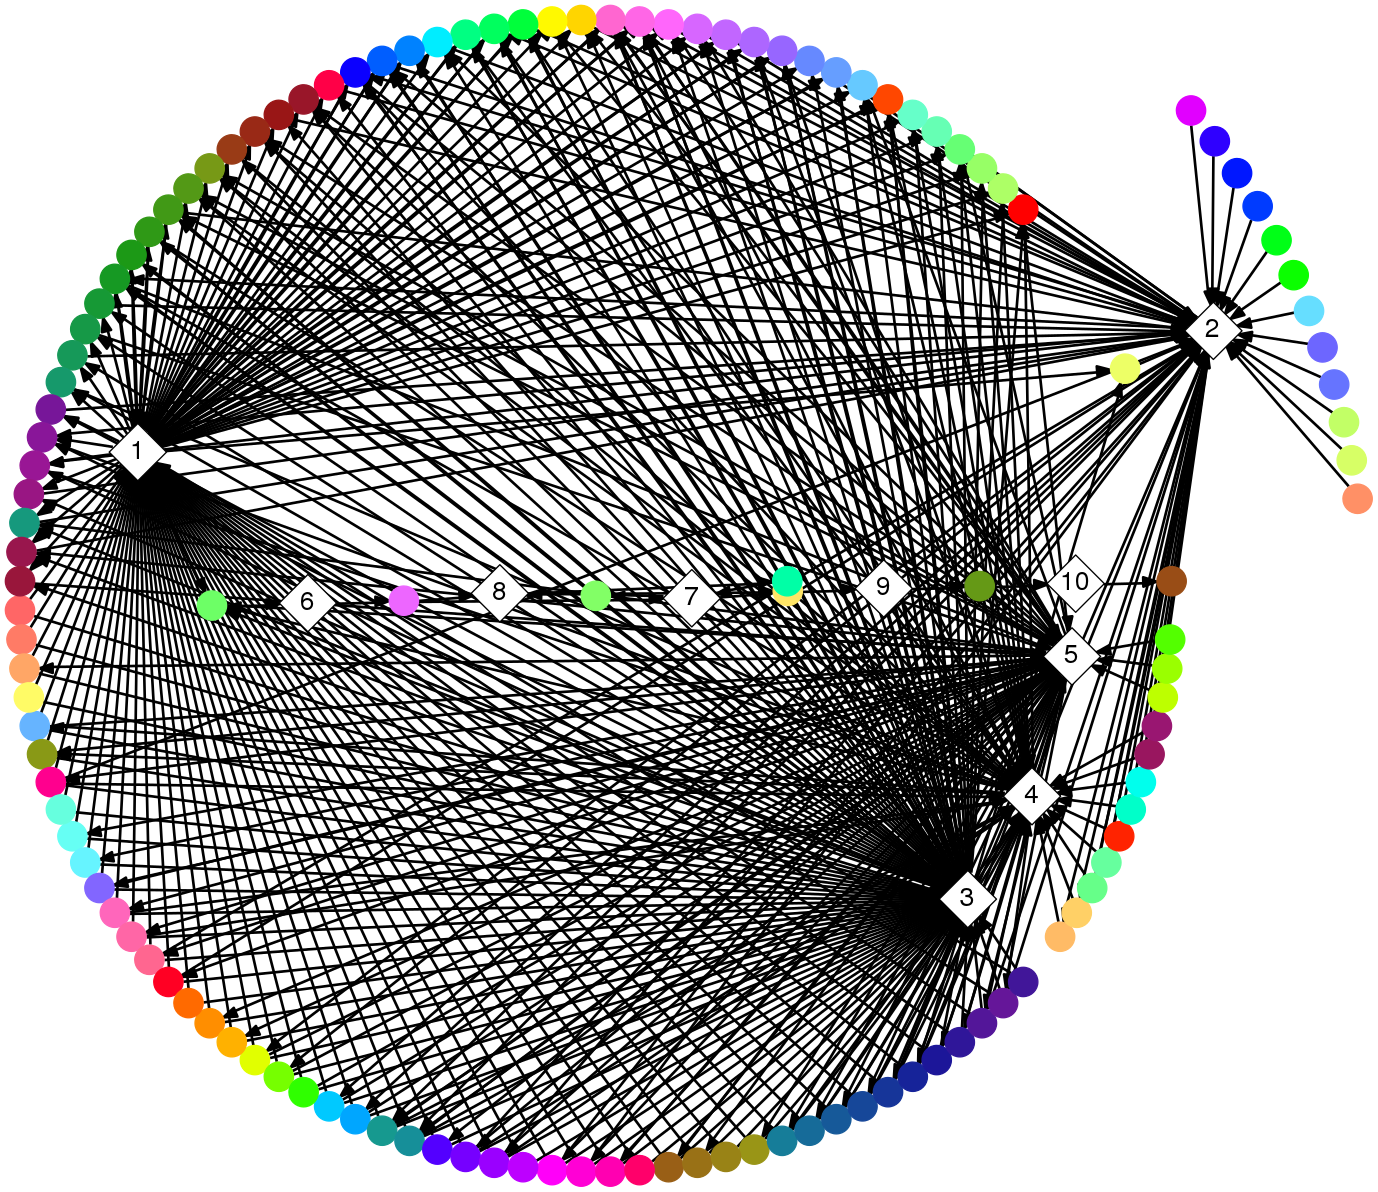

In [88]:
molecules = ['C00031_2', 'C00092_4', 'C00085_2', 'C00354_1',
        'C00111_1', 'C00118_2', 'C00236_3', 'C00197_1',
        'C00631_1', 'C00074_1', 'C00022_1', 'C00118_2']

cscale = gd.get_N_HexCol(len(molecules))
glynodecolors = {}
for m in range(len(molecules)):
    glynodecolors[molecules[m]] = '#%s' % cscale[m]


imgfile = 'glyco/graph_pics/all_glycolysis.png'
colors = make_graph_img_net_neato(pathar['strrepr'], imgfile, 
                                  fontsize=20, circlelabels=False, 
                                  diamondlabels=True, directed=True)
Image(imgfile)

/trombone1/home/scalhoun/pics/graphs/gly_colors_image.png


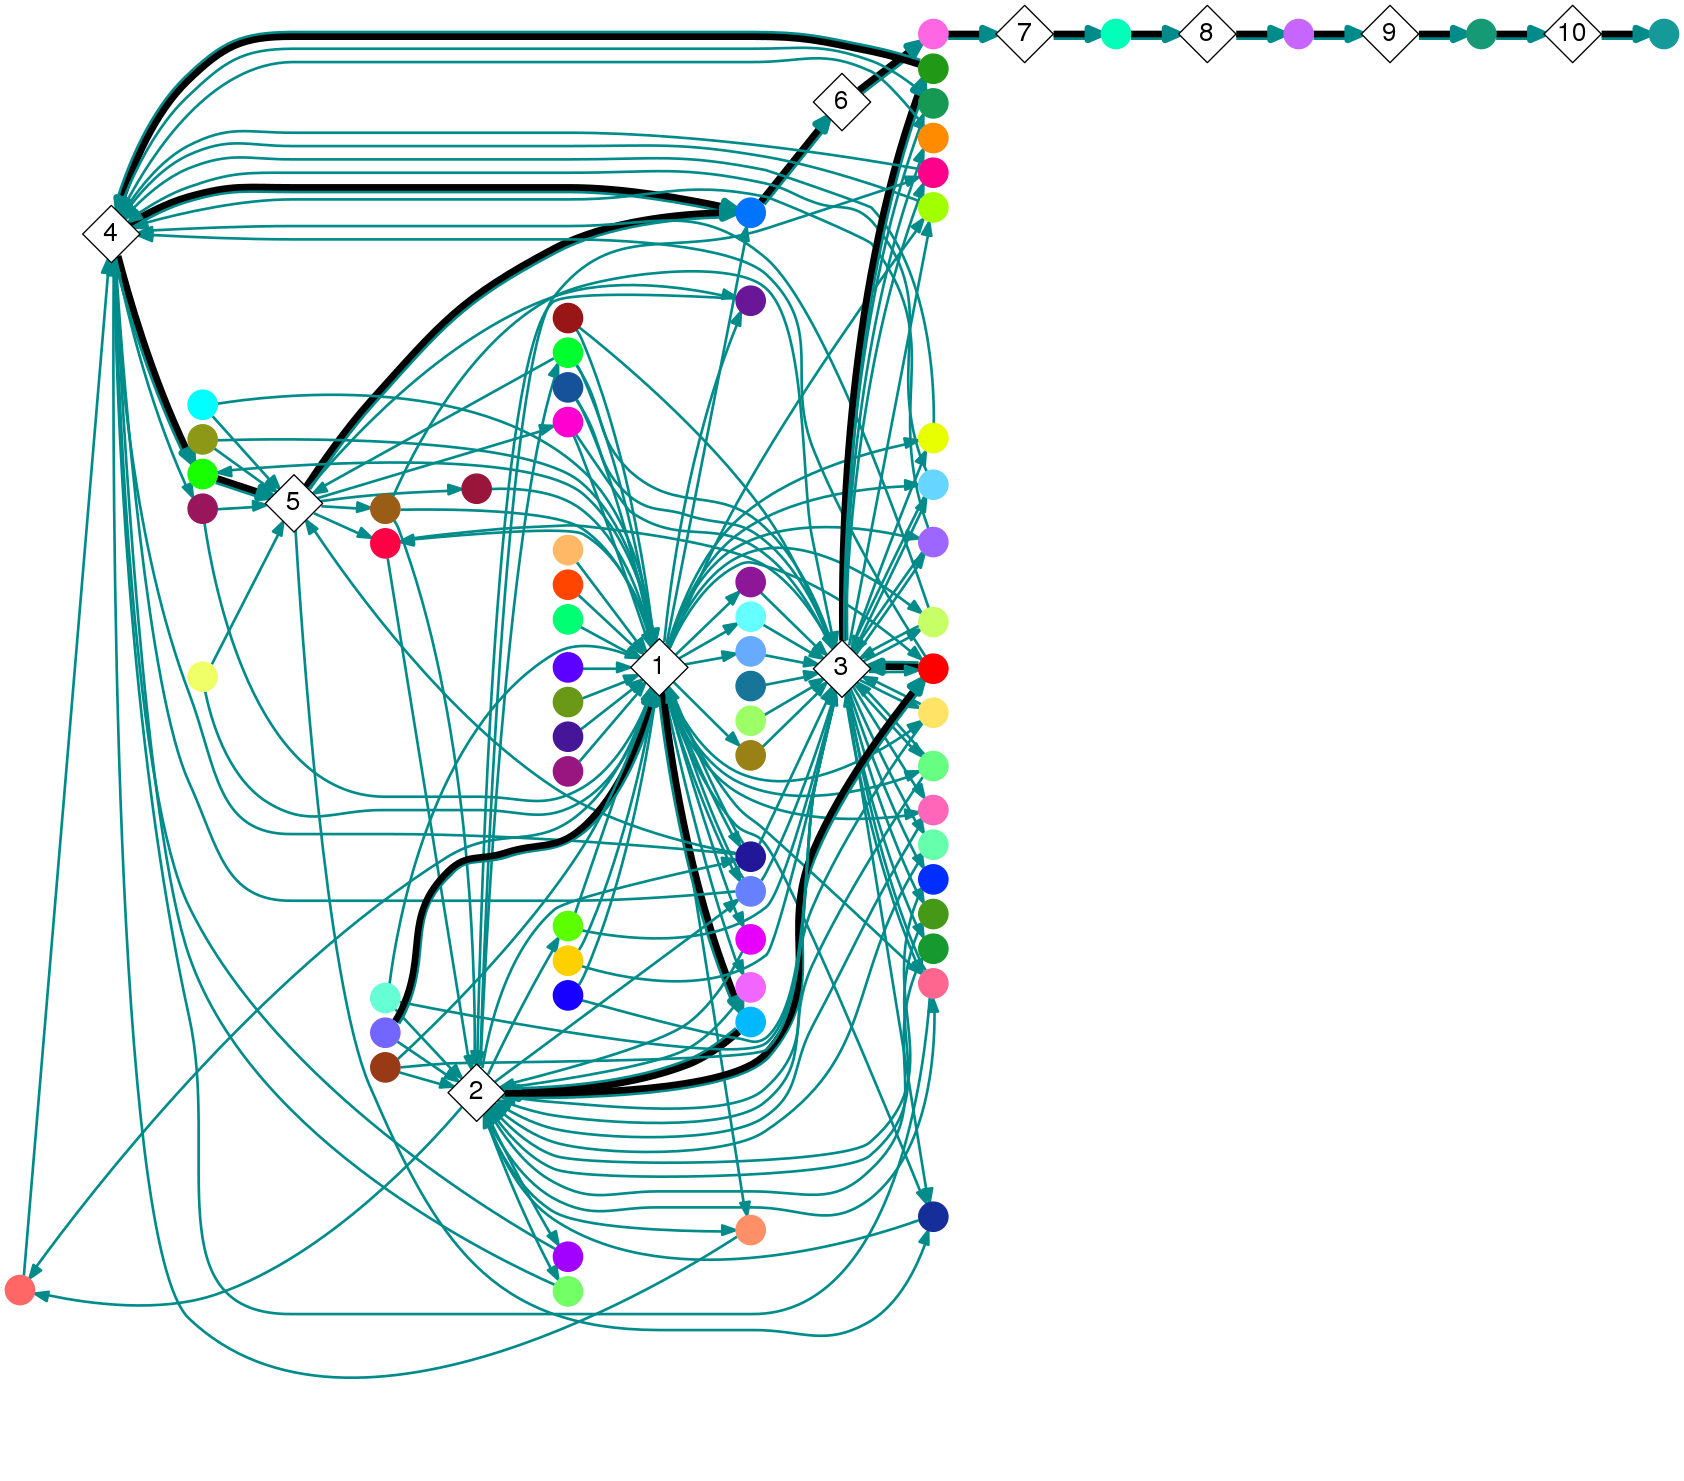

In [10]:
tese = [('C00031_2', '1'), ('C00092_4', '2'), ('C00085_2', '3'), ('C00354_1', '4'), 
        ('C00111_1', '5'), ('C00118_2', '6'), ('C00236_3', '7'), ('C00197_1', '8'), 
        ('C00631_1', '9'), ('C00074_1', '10')]
teep = [('1', 'C00092_4'), ('2', 'C00085_2'), ('3', 'C00354_1'), ('4', 'C00111_1'),
        ('5', 'C00118_2'), ('6', 'C00236_3'), ('7', 'C00197_1'), ('8', 'C00631_1'), 
        ('9', 'C00074_1'), ('10', 'C00022_1'), ('4', 'C00118_2')]
imgfile = '/trombone1/home/scalhoun/pics/graphs/gly_colors_image.png'
print imgfile
gd.make_graph_img_net_single(goodsolns['strrepr'], imgfile, nodecolordict=colors, fontsize=20,
                              circlelabels=False, diamondlabels=True, directed=True,
                              true_edges_subenz=tese, true_edges_enzprod=teep,
                              dotfile='gly_graph.dot')
Image(imgfile)

In [89]:
import pygraphviz as pgv

def make_graph_img_net_neato(paths, outfilename, nodecolordict=None, index_true=None, fontsize=22,
                       circlelabels=False, diamondlabels=True, directed=False,
                       dotfile=None, true_edges_subenz=[], true_edges_enzprod=[]):

    cscale = gd.get_N_HexCol(len(paths))

    nodes = []
    edges = {}

    circles = []

    idxpathdict = {i:paths[i] for i in range(len(paths))}
    for pathkey in idxpathdict.keys():
        currpath = idxpathdict[pathkey]
        currnodes = currpath.split(' -> ')
        nodes.extend(currnodes)
        for pos in range(len(currnodes)):
            if pos % 2 == 0:
                circles.append(currnodes[pos])
        for n in range(len(currnodes)-1):
            edge = (currnodes[n], currnodes[n+1])
            if edge not in edges.keys():
                edges[edge] = [pathkey]
            else:
                edges[edge].append(pathkey)

    if len(true_edges_subenz) > 0 and len(true_edges_enzprod) > 0:
        index_true = -1
        for edge_subenz in true_edges_subenz:
            nodes.append(edge_subenz[0])
            nodes.append(edge_subenz[1])
            circles.append(edge_subenz[0])
            if edge_subenz not in edges.keys():
                edges[edge_subenz] = [-1]
            else:
                edges[edge_subenz].append(-1)
        for edge_enzprod in true_edges_enzprod:
            nodes.append(edge_enzprod[0])
            nodes.append(edge_enzprod[1])
            circles.append(edge_enzprod[1])
            if edge_enzprod not in edges.keys():
                edges[edge_enzprod] = [-1]
            else:
                edges[edge_enzprod].append(-1)

    nodes = list(set(nodes))
    circles = list(set(circles))

    if nodecolordict is None:
        cscale = gd.get_N_HexCol(len(circles))
        new_nodecolordict = {}
        for i in range(len(circles)):
            new_nodecolordict[circles[i]] = '#' + cscale[i]
        nodecolordict = new_nodecolordict

    
#     tempnodecolordict = nodecolordict.copy()
#     enzs = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
#     for n in nodes:
#         if n not in nodecolordict.keys() and n not in enzs:
#             tempnodecolordict[n] = '#a6a6a6'
        
    G = gd.build_pvgraph(nodes, edges, nodecolordict, None, index_true,
                      [], fontsize, circles=circles, circlelabels=circlelabels,
                      diamondlabels=diamondlabels, directed=directed, labeldict={})

    G.layout(prog="neato")
    G.draw(outfilename)
    if dotfile is not None:
        G.write(dotfile)
    return nodecolordict
